In [20]:
#CNN-based Localization System for an Autonomous Mobile Robot
#2023-2024 --- BLG561E Deep Learning Term Project -----
#Fulya Yenilmez, Emre Can Contarlı -----

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import random
from tensorflow.keras.applications import VGG19, VGG16
from tensorflow.keras.applications.vgg19 import preprocess_input

In [2]:
# Seed
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)

set_seed(42)


In [3]:
# Data loading
data = pd.read_csv('dataset_images_dl_pro.csv')
data.columns = data.columns.str.strip()
data = data['Images;x;y;yaw'].str.split(';', expand=True)
data.columns = ['Images', 'x', 'y', 'yaw']

In [4]:
# Orientation value yaw is set to 0 or 1 (north or south)
def classify_yaw(yaw):
    yaw = float(yaw)
    if yaw >= 0 and yaw < 180:
        return 0  # north
    else:
        return 1  # south
        
data['yaw_class'] = data['yaw'].apply(classify_yaw)

# Normalization with MinMaxScaler 
scaler = MinMaxScaler()
data[['x', 'y']] = scaler.fit_transform(data[['x', 'y']].astype(float))

# updating the target values 
targets = data[['x', 'y']].values.astype(float)
yaw_classes = data['yaw_class'].values

In [5]:
# data loading and preprocessing 
def load_and_preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = image / 255.0  
    return image, label

In [6]:
file_paths = data['Images'].values
xy_labels = data[['x', 'y']].values
yaw_labels = data['yaw_class'].values

dataset = tf.data.Dataset.from_tensor_slices((file_paths, (xy_labels, yaw_labels)))
dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

2024-05-21 08:52:09.731835: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2024-05-21 08:52:09.731903: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2024-05-21 08:52:09.731916: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2024-05-21 08:52:09.731964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-21 08:52:09.731990: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
# data augmentation applied 
def augment(image, label):
    #image = tf.image.random_flip_left_right(image) #this is not right approach
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.3)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    return image, label

In [8]:
# Splitting the dataset into training, testing, and validation
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size)

In [9]:
# data augmentation only applied to the training set
train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)


In [10]:
batch_size = 32
train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
#Uploading the VGG16 model weights and architecture 
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
#freeze all the layers of the VGG16
for layer in base_model.layers:
    layer.trainable = False

In [22]:
#Top layers 
inputs = base_model.input
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

output_xy = Dense(2, name='xy_output')(x)  # x and y output - regression
output_yaw = Dense(1, activation='sigmoid', name='yaw_output')(x)  # yaw output - classification

model = tf.keras.Model(inputs=inputs, outputs=[output_xy, output_yaw])

In [23]:
#Model compile with Adam optimizer and mse and binary crossentropy
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss={'xy_output': 'mse', 'yaw_output': 'binary_crossentropy'},
              metrics={'xy_output': 'mse', 'yaw_output': 'accuracy'})

In [24]:
# Early stopping to overcome the overfitting and model checkpoint to save the model
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_classification_yaw.keras', monitor='val_loss', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)



In [25]:

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=300,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr])


Epoch 1/300
484/484 ━━━━━━━━━━━━━━━━━━━━ 100s 203ms/step - loss: 1.6116 - xy_output_mse: 0.1807 - yaw_output_accuracy: 0.8829 - val_loss: 1.0061 - val_xy_output_mse: 0.1590 - val_yaw_output_accuracy: 0.6774 - learning_rate: 1.0000e-04
Epoch 2/300
484/484 ━━━━━━━━━━━━━━━━━━━━ 101s 208ms/step - loss: 0.9098 - xy_output_mse: 0.1910 - yaw_output_accuracy: 0.6754 - val_loss: 1.0164 - val_xy_output_mse: 0.2510 - val_yaw_output_accuracy: 0.6774 - learning_rate: 1.0000e-04
Epoch 3/300
484/484 ━━━━━━━━━━━━━━━━━━━━ 100s 206ms/step - loss: 0.7287 - xy_output_mse: 0.1930 - yaw_output_accuracy: 0.7791 - val_loss: 0.9812 - val_xy_output_mse: 0.1771 - val_yaw_output_accuracy: 0.6774 - learning_rate: 1.0000e-04
Epoch 4/300
484/484 ━━━━━━━━━━━━━━━━━━━━ 99s 203ms/step - loss: 0.7162 - xy_output_mse: 0.1834 - yaw_output_accuracy: 0.8109 - val_loss: 0.8434 - val_xy_output_mse: 0.1829 - val_yaw_output_accuracy: 0.6774 - learning_rate: 1.0000e-04
Epoch 5/300
484/484 ━━━━━━━━━━━━━━━━━━━━ 99s 204ms/step - los

In [27]:
#Testing with test set
test_results = model.evaluate(test_dataset)
print(f"Test loss: {test_results[0]}")
print(f"Test XY MSE: {test_results[1]}")
print(f"Test Yaw Accuracy: {test_results[2]}")

61/61 ━━━━━━━━━━━━━━━━━━━━ 13s 161ms/step - loss: 0.1150 - xy_output_mse: 0.0462 - yaw_output_accuracy: 0.9980
Test loss: 0.15763448178768158
Test XY MSE: 0.02753017656505108
Test Yaw Accuracy: 0.9963824152946472


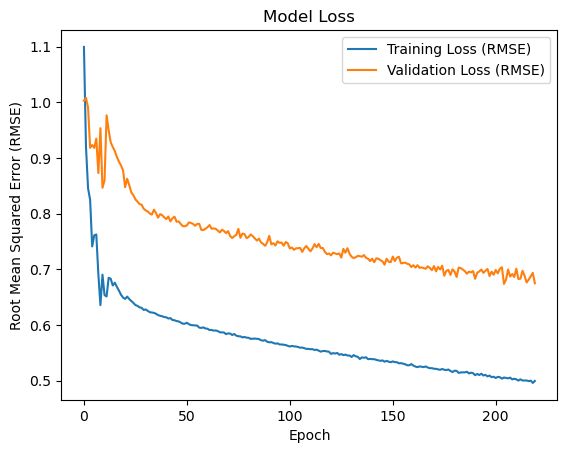

In [30]:
# Training and validation loss graph with RMSE 
import matplotlib.pyplot as plt
plt.plot(np.sqrt(history.history['loss']), label='Training Loss (RMSE)')
plt.plot(np.sqrt(history.history['val_loss']), label='Validation Loss (RMSE)')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.legend(loc='upper right')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-05-21 16:05:09.288316: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


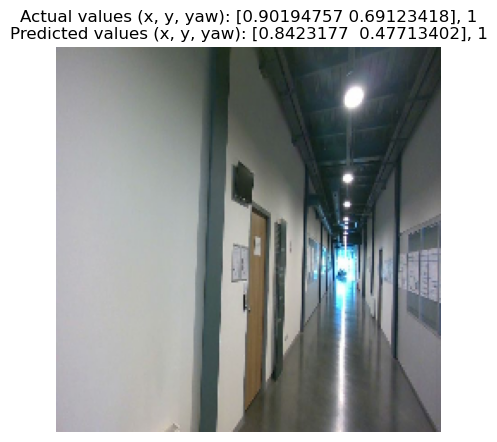

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


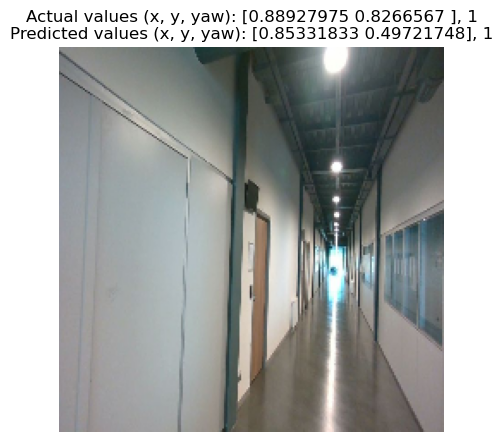

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


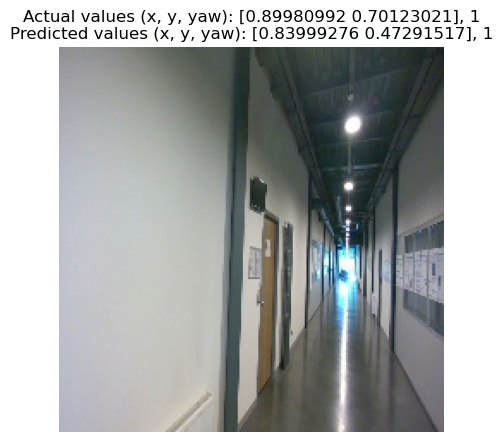

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


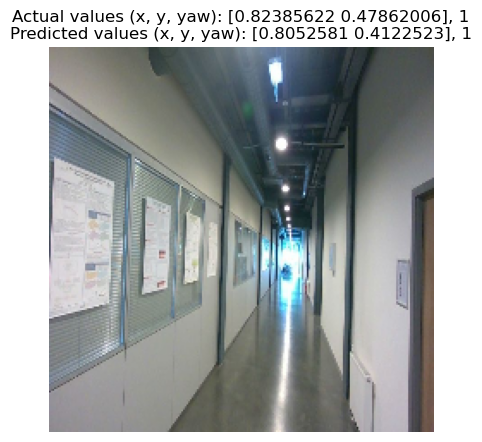

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


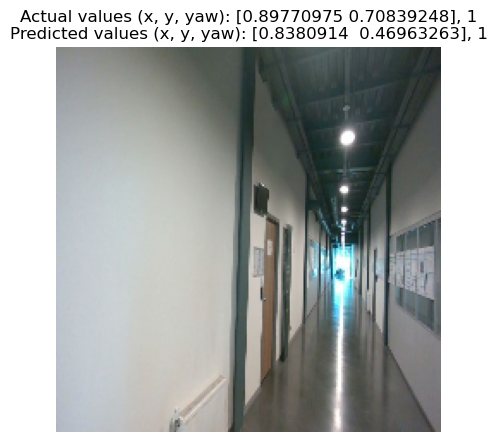

In [46]:
import random

#Testing on the test set images 
test_examples = list(test_dataset.unbatch().as_numpy_iterator())

# random prediction from the test data 
def plot_random_prediction(test_examples, model):
    random_example = random.choice(test_examples)

    image, (true_xy, true_yaw) = random_example
    image = tf.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    pred_xy = prediction[0][0]
    pred_yaw = prediction[1][0]
    
    # yaw is 0 or 1 
    pred_yaw = 1 if pred_yaw > 0.5 else 0

    plt.figure(figsize=(5, 5))
    plt.imshow(image[0])
    plt.title(f"Actual values (x, y, yaw): {true_xy}, {true_yaw}\n"
              f"Predicted values (x, y, yaw): {pred_xy}, {pred_yaw}")
    plt.axis('off')
    plt.show()

# 5 random images 
for _ in range(5):
    plot_random_prediction(test_examples, model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


2024-05-21 16:01:48.544205: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


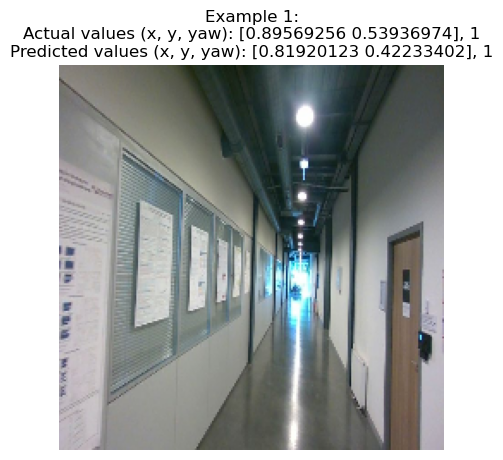

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


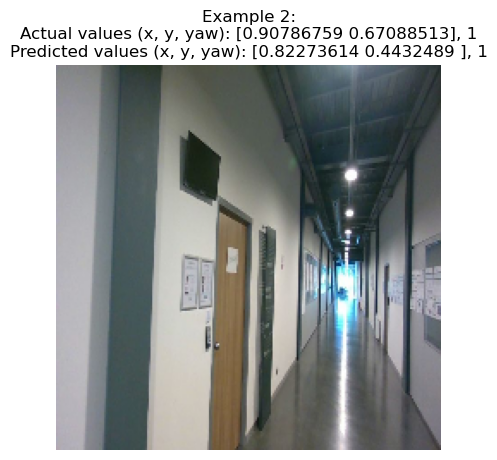

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


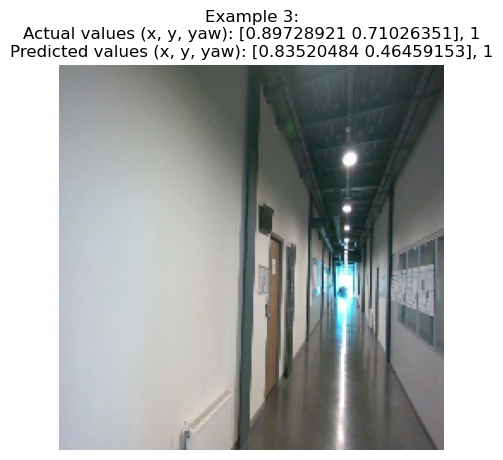

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


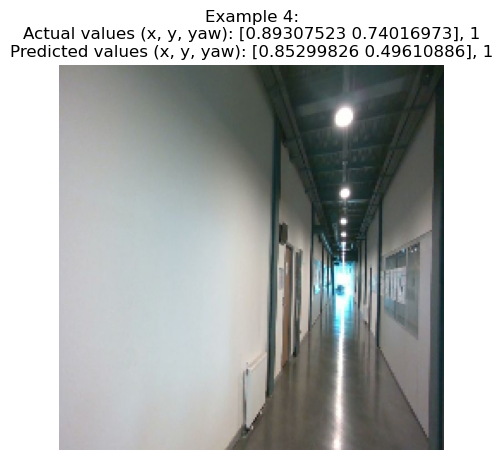

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


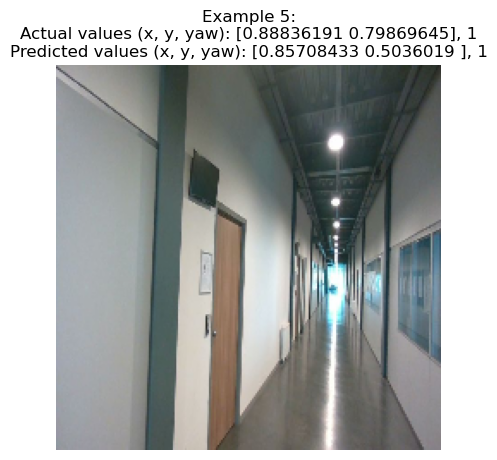

In [39]:
import random

#Testing on the test set images 
test_examples = list(test_dataset.unbatch().as_numpy_iterator())

# random prediction from the test data 
def plot_random_prediction(test_examples, model):
    random_example = random.choice(test_examples)

    image, (true_xy, true_yaw) = random_example
    image = tf.expand_dims(image, axis=0)  
    prediction = model.predict(image)
    pred_xy = prediction[0][0]
    pred_yaw = prediction[1][0]
    
    # yaw is 0 or 1 
    pred_yaw = 1 if pred_yaw > 0.5 else 0

    plt.figure(figsize=(5, 5))
    plt.imshow(image[0])
    plt.title(f"Actual values (x, y, yaw): {true_xy}, {true_yaw}\n"
              f"Predicted values (x, y, yaw): {pred_xy}, {pred_yaw}")
    plt.axis('off')
    plt.show()

# 5 random images 
for _ in range(5):
    plot_random_prediction(test_examples, model)


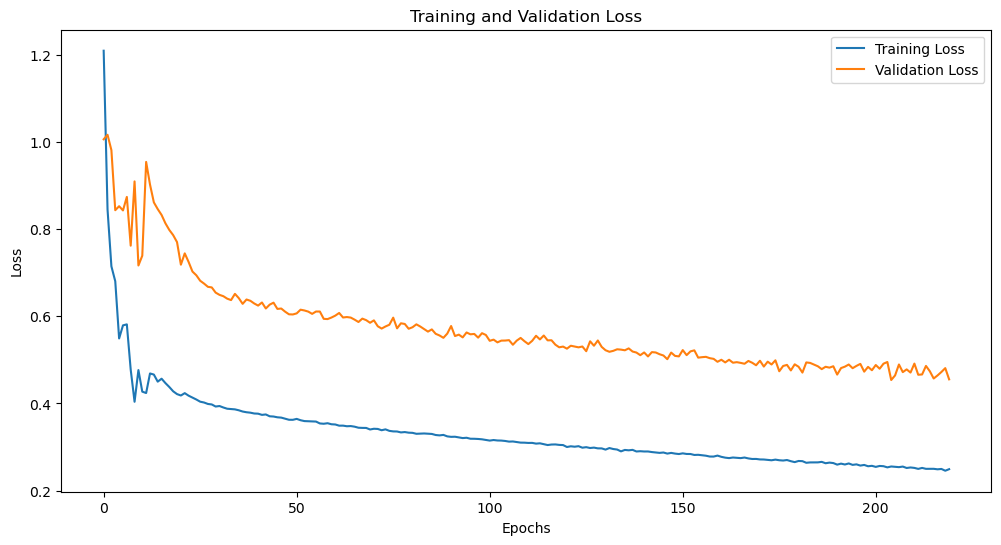

In [84]:
# only traning and validation loss graphs 
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

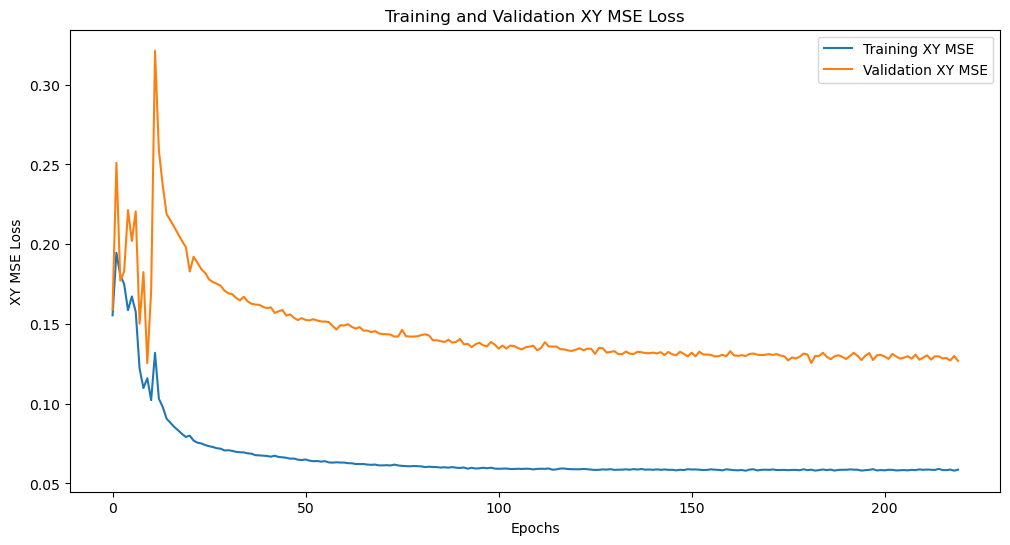

In [35]:
# Mean square error graph for training and validation
plt.figure(figsize=(12, 6))
plt.plot(history.history['xy_output_mse'], label='Training XY MSE')
plt.plot(history.history['val_xy_output_mse'], label='Validation XY MSE')
plt.xlabel('Epochs')
plt.ylabel('XY MSE Loss')
plt.title('Training and Validation XY MSE Loss')
plt.legend()
plt.show()

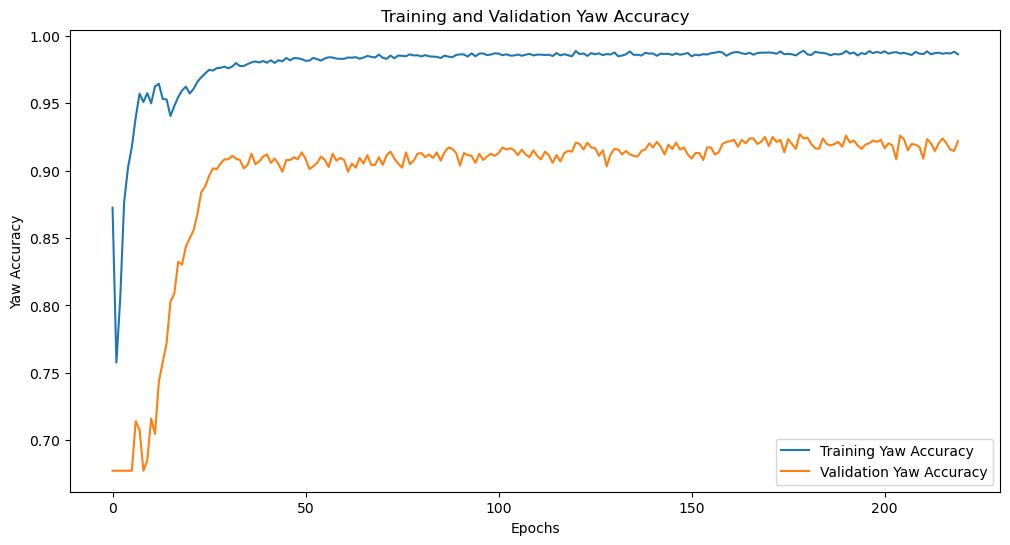

In [36]:
# Yaw accuracy graph
plt.figure(figsize=(12, 6))
plt.plot(history.history['yaw_output_accuracy'], label='Training Yaw Accuracy')
plt.plot(history.history['val_yaw_output_accuracy'], label='Validation Yaw Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Yaw Accuracy')
plt.title('Training and Validation Yaw Accuracy')
plt.legend()
plt.show()

In [83]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 224, 224,  │      1,792 │ input_layer_1[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 224, 224,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 112, 112,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 112, 112,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 112, 112,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 56, 56,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 56, 56,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 56, 56,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 56, 56,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 28, 28,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 28, 28,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 28, 28,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 28, 28,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 14, 14,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 14, 14,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 14, 14,    │  2,359,808 │ block5_conv1[0][

 Total params: 24,350,027 (92.89 MB)

 Trainable params: 3,211,779 (12.25 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 6,423,560 (24.50 MB)

In [49]:
#mse_value = 0.02753017656505108
# error for coordinates in meters 
rmse_value = np.sqrt(test_results[1])
print(f"Average XY error (in meters): {rmse_value:.4f} meters")

Average XY error (in meters): 0.1659 meters
